In [1]:
# pip install ipympl
%matplotlib widget
%load_ext autoreload

In [17]:
%autoreload
from logparser import get_events_from, LogData
from plotter import plot_gc, plot_membalancer_heap_rule, plot_full_gc_info
from GarbageCollector import MemBalancer
import numpy as np
import matplotlib.pyplot as plt

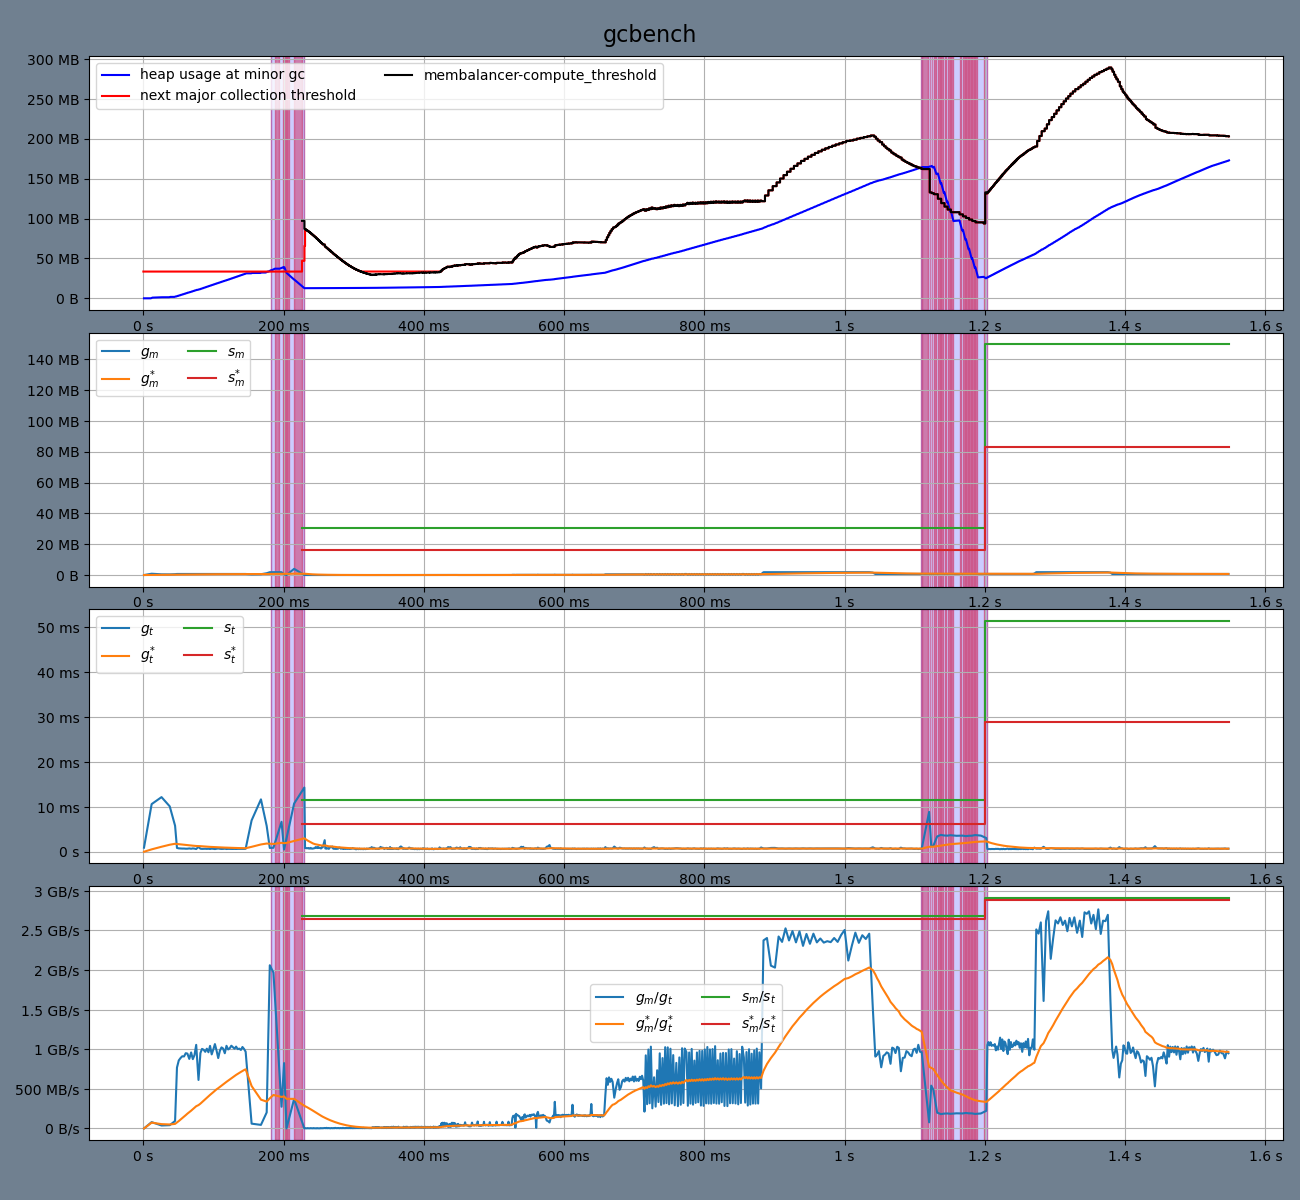

In [14]:
gcbench_data = LogData("logs/gcbench")
s_m_line = plot_full_gc_info(gcbench_data, "gcbench", 3)

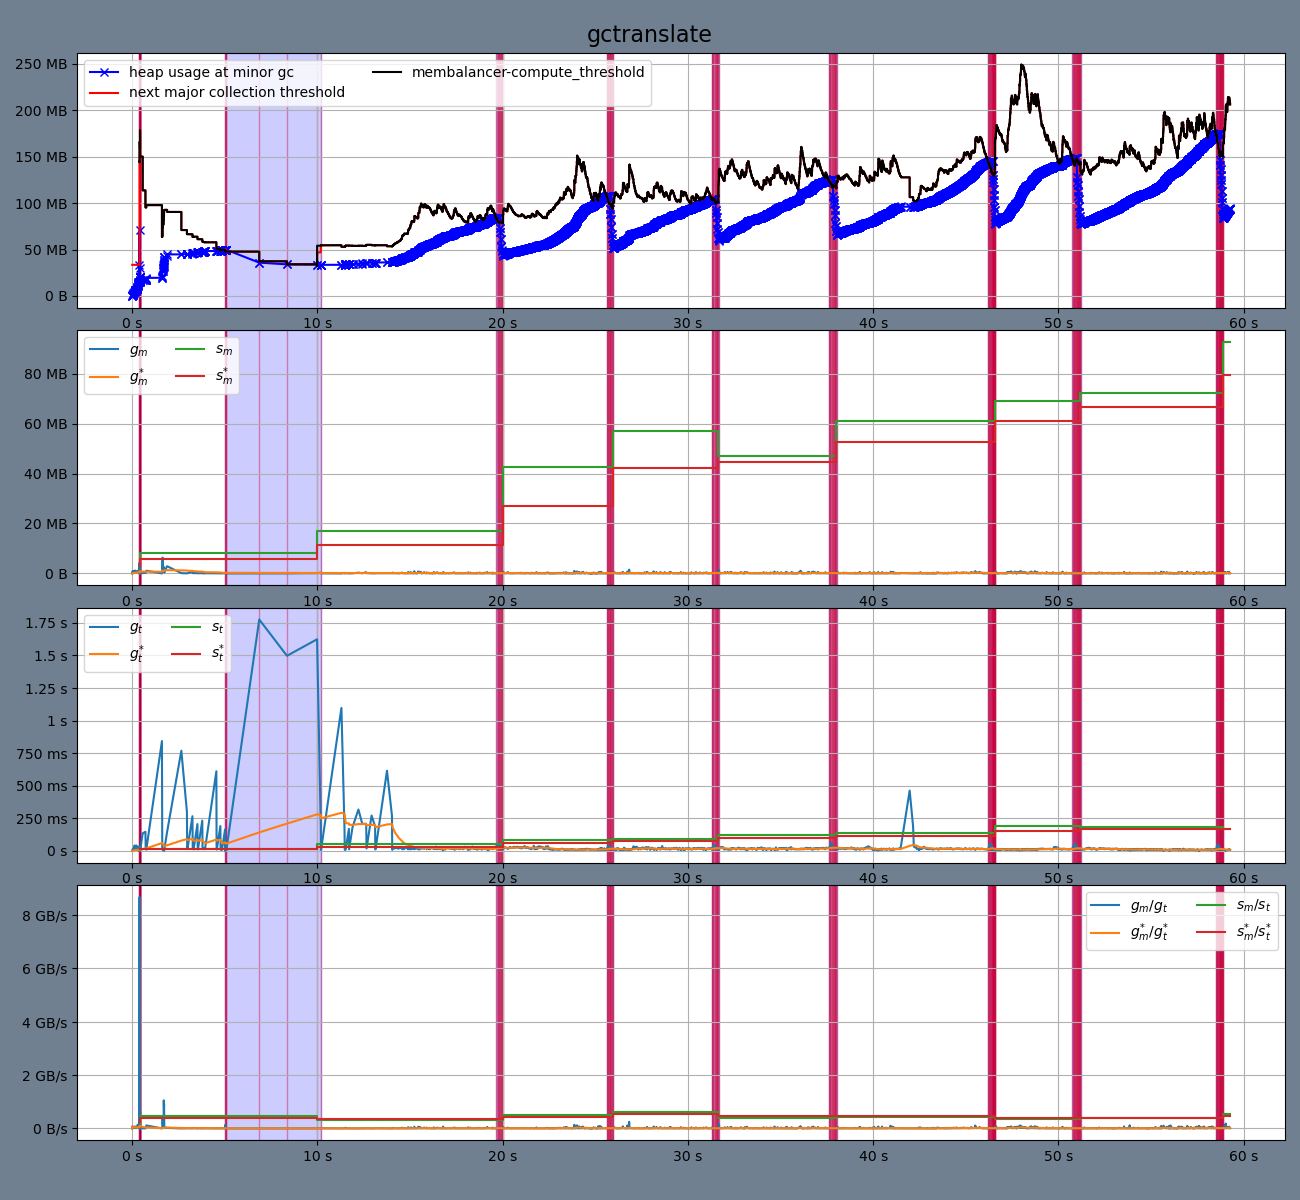

In [19]:
gctranslate_data = LogData("logs/gctranslate")
plot_full_gc_info(gctranslate_data, "gctranslate", 4)

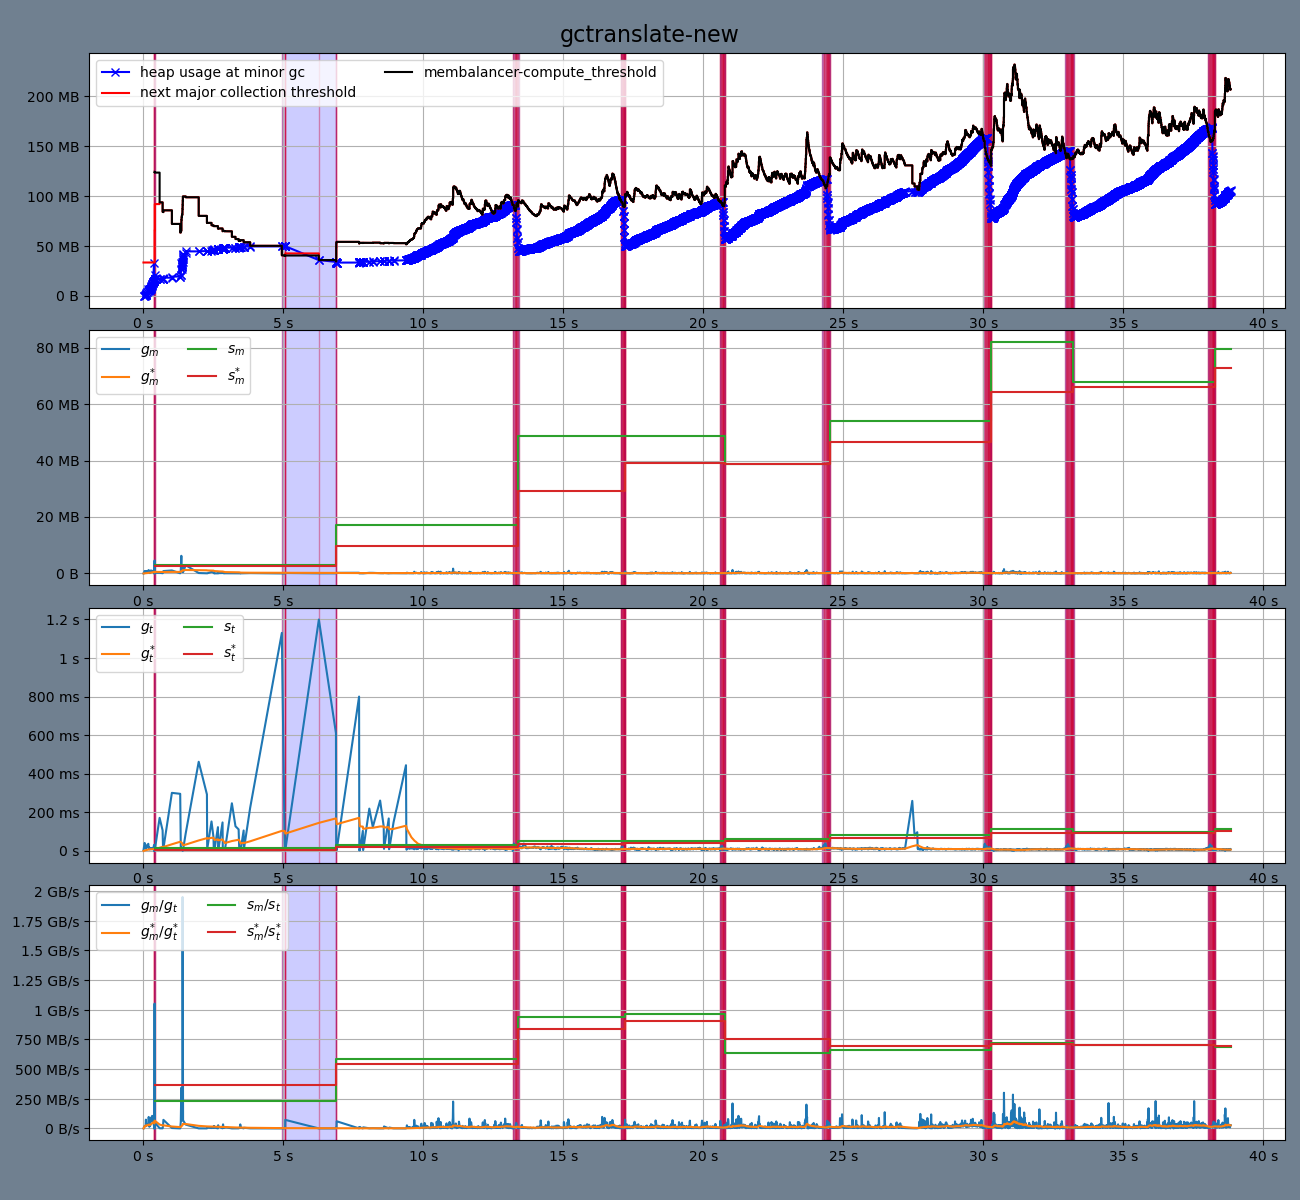

In [20]:
gctranslate2_data = LogData("logs/gctranslate-new")
plot_full_gc_info(gctranslate2_data, "gctranslate-new", 4)

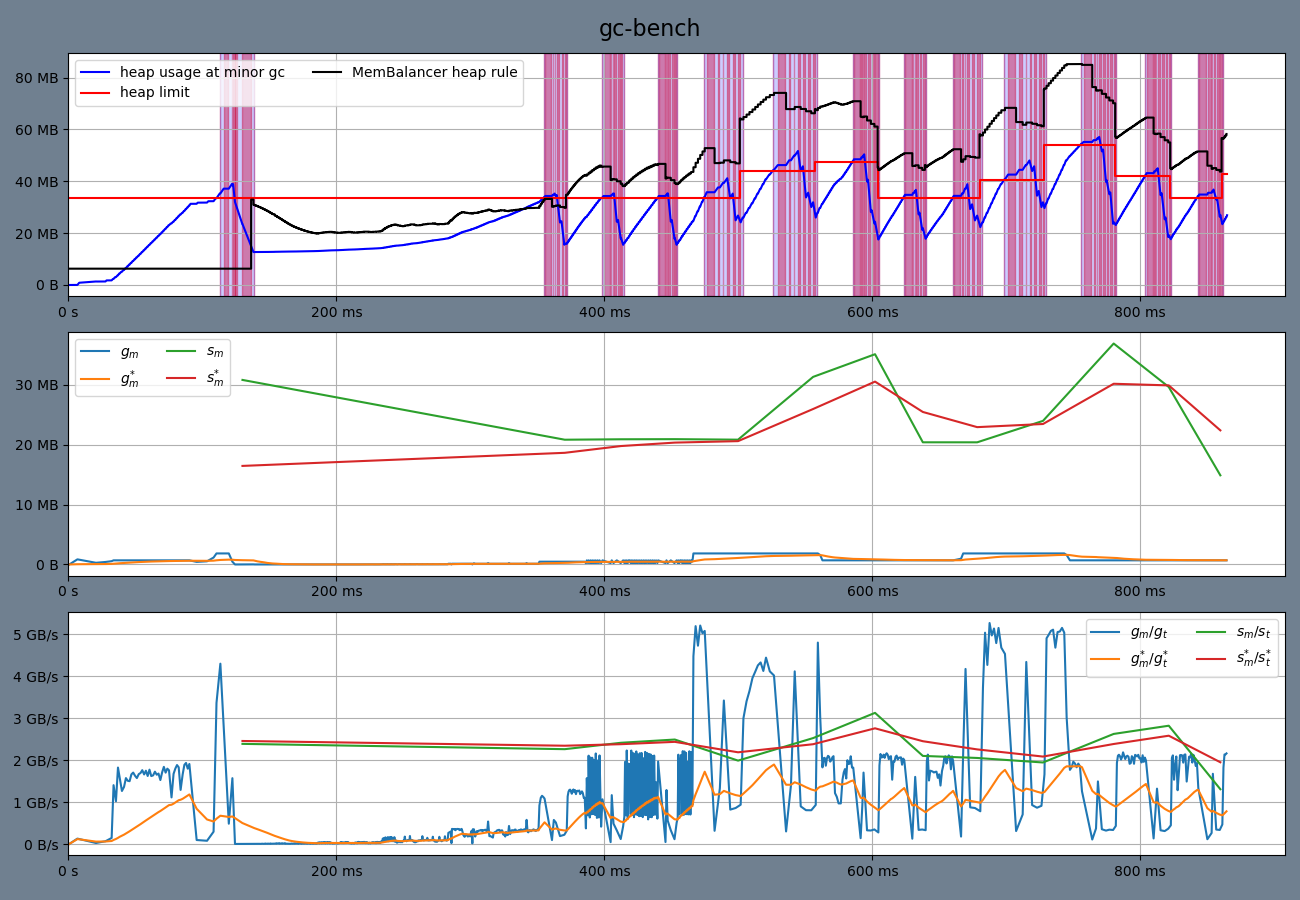

In [15]:
gcbench_events = get_events_from("logs/gcbench-old")
plot_gc(gcbench_events, "gc-bench", fignum=1)
mem_balancer = MemBalancer(TUNING=1e-8, minimum_extra_heap=2*1024**2)
mem_balancer.L_smoothed = 1024
mem_balancer.s_m_smoothed = 2 * 1024**2
mem_balancer.s_t_smoothed = 1/2024
plot_membalancer_heap_rule(gcbench_events, mem_balancer,fignum=1)
plt.xlim(left=0)
plt.show()


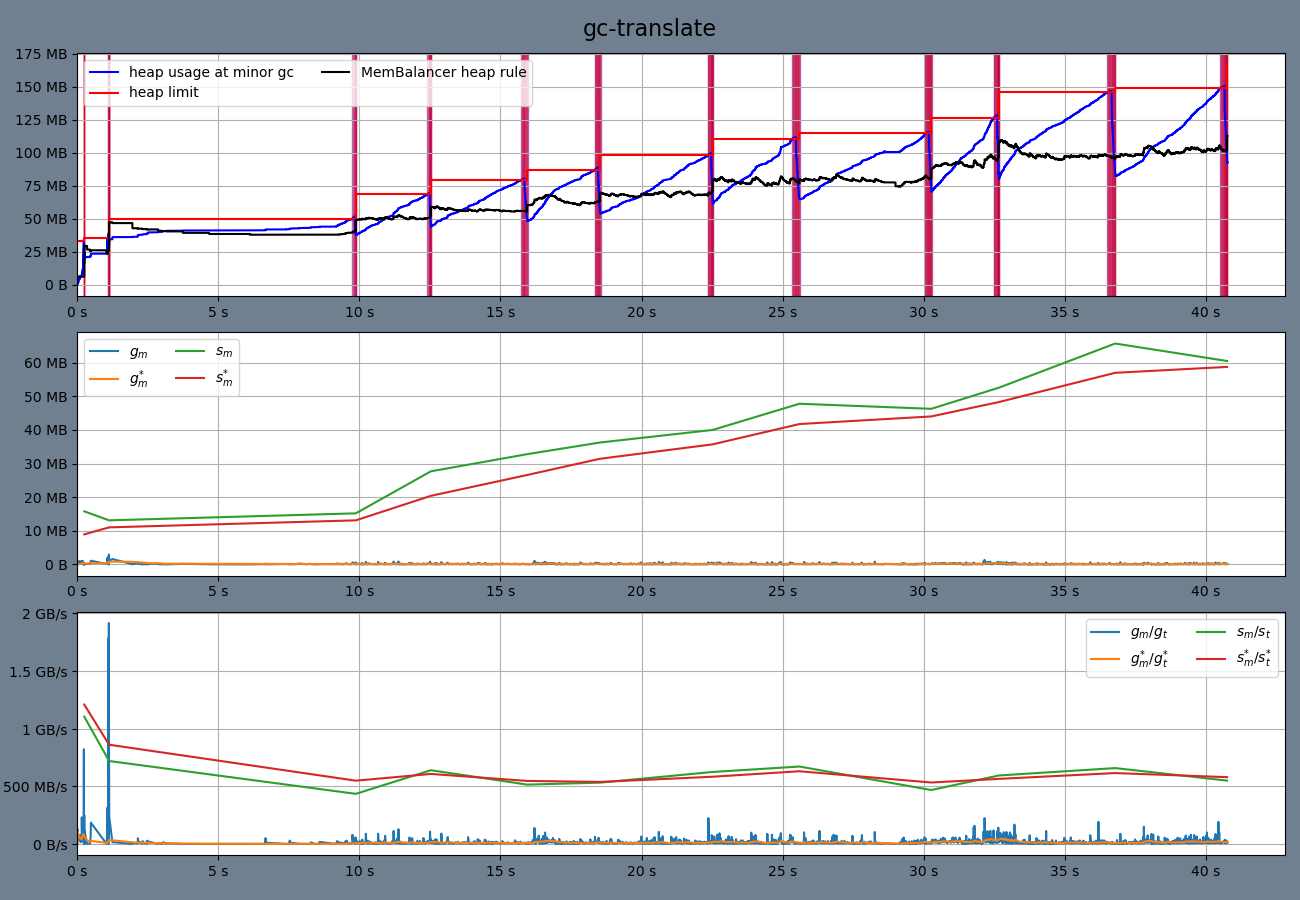

In [21]:
gctranslate_events = get_events_from("logs/gctranslate-old")
plot_gc(gctranslate_events, "gc-translate", fignum=2)
mem_balancer = MemBalancer(TUNING=1e-8, minimum_extra_heap=2*1024**2)
mem_balancer.L_smoothed = 1024
mem_balancer.s_m_smoothed = 2 * 1024**2
mem_balancer.s_t_smoothed = 1/2024
plot_membalancer_heap_rule(gctranslate_events, mem_balancer, fignum=2)
plt.xlim(left=0)
plt.show()

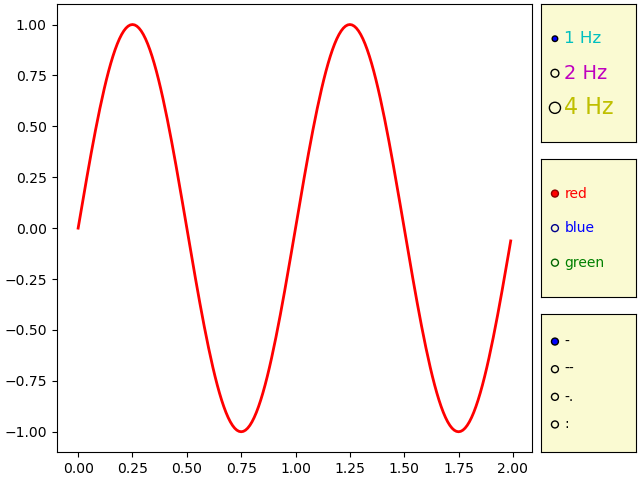

In [22]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import RadioButtons

t = np.arange(0.0, 2.0, 0.01)
s0 = np.sin(2*np.pi*t)
s1 = np.sin(4*np.pi*t)
s2 = np.sin(8*np.pi*t)

fig, ax = plt.subplot_mosaic(
    [
        ['main', 'freq'],
        ['main', 'color'],
        ['main', 'linestyle'],
    ],
    width_ratios=[5, 1],
    layout='constrained',
)
l, = ax['main'].plot(t, s0, lw=2, color='red')

radio_background = 'lightgoldenrodyellow'

ax['freq'].set_facecolor(radio_background)
radio = RadioButtons(ax['freq'], ('1 Hz', '2 Hz', '4 Hz'),
                     label_props={'color': 'cmy', 'fontsize': [12, 14, 16]},
                     radio_props={'s': [16, 32, 64]})


def hzfunc(label):
    hzdict = {'1 Hz': s0, '2 Hz': s1, '4 Hz': s2}
    ydata = hzdict[label]
    l.set_ydata(ydata)
    fig.canvas.draw()


radio.on_clicked(hzfunc)

ax['color'].set_facecolor(radio_background)
radio2 = RadioButtons(
    ax['color'], ('red', 'blue', 'green'),
    label_props={'color': ['red', 'blue', 'green']},
    radio_props={
        'facecolor': ['red', 'blue', 'green'],
        'edgecolor': ['darkred', 'darkblue', 'darkgreen'],
    })


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw()


radio2.on_clicked(colorfunc)

ax['linestyle'].set_facecolor(radio_background)
radio3 = RadioButtons(ax['linestyle'], ('-', '--', '-.', ':'))


def stylefunc(label):
    l.set_linestyle(label)
    fig.canvas.draw()


radio3.on_clicked(stylefunc)

plt.show()